In [1]:
from DPC import DPC
from load import Load
load = Load()
data = load.readPd('dataset/gauss_data.txt')

dpc = DPC(data)
dpc.calRho(dc=1,kernel='gaussian')
dpc.calDel()
dpc.calGam()
dpc.cluster()


937
[937 343]


[Text(0.5, 1.0, 'decision graph'),
 Text(0.5, 0, '$\\rho$'),
 Text(0, 0.5, '$\\delta$')]

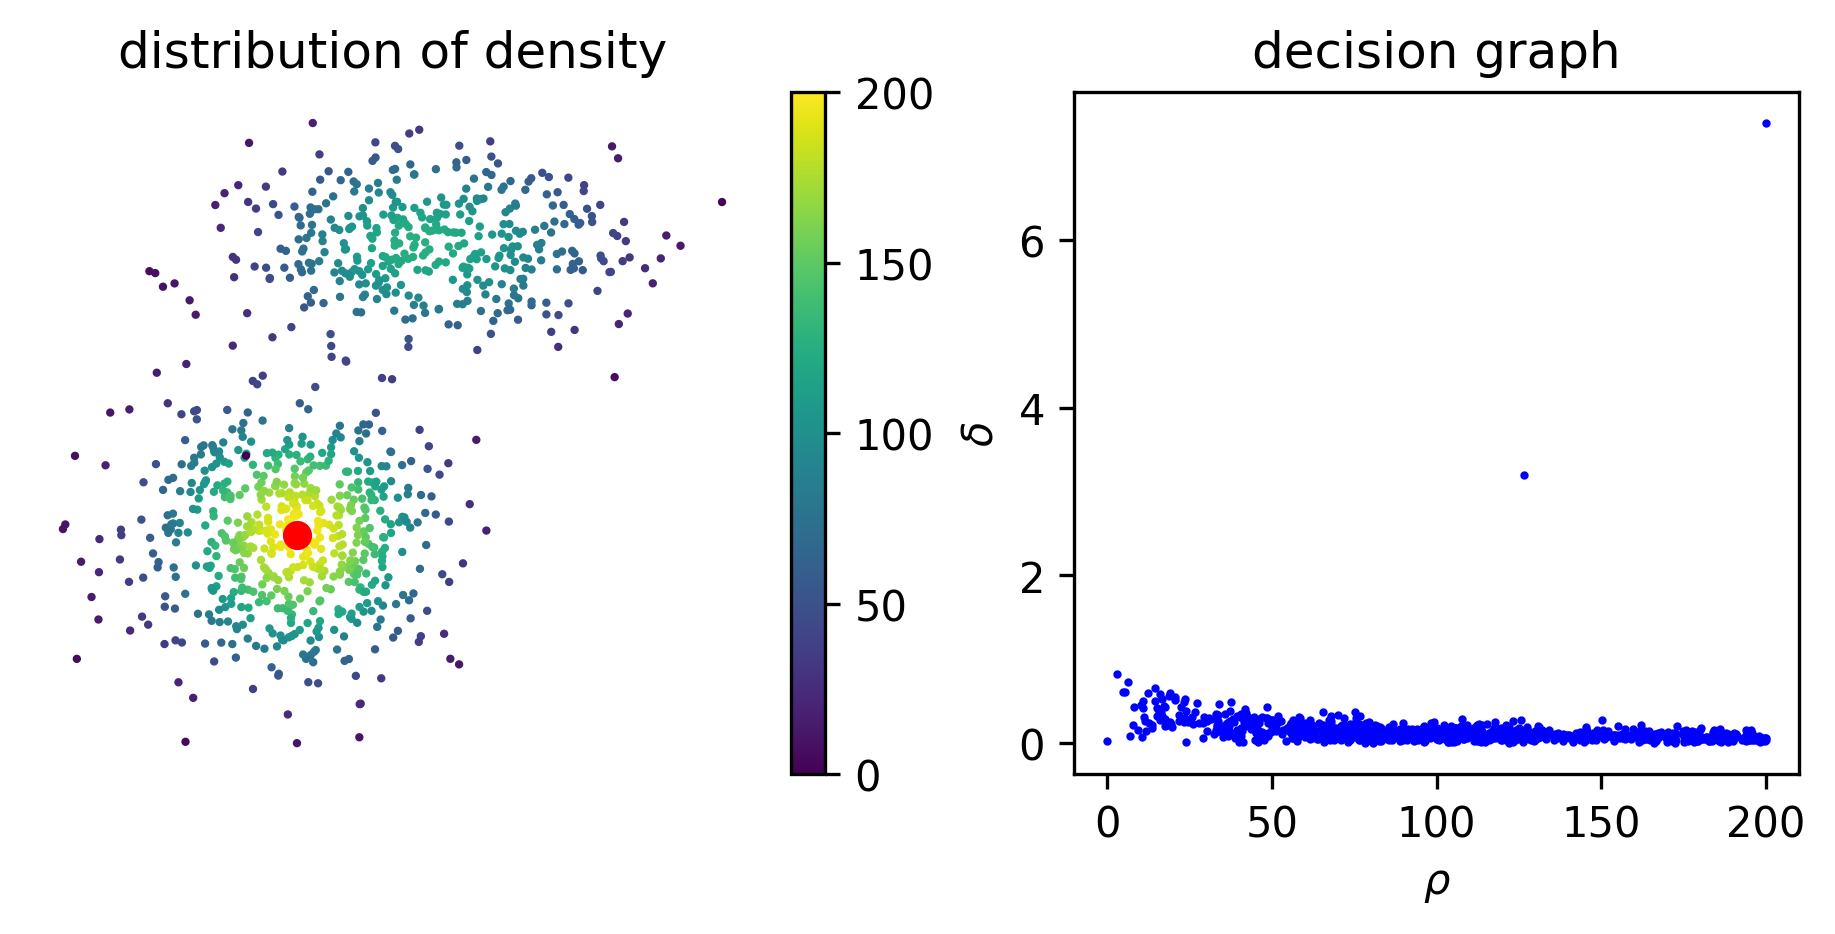

In [6]:
import matplotlib.pyplot as plt
data=dpc.df
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300, constrained_layout=True)
data.plot.scatter(x="x", y='y', s=1, c=data['rho'].values, cmap='viridis', ax=ax[0])
ax[0].scatter(data.loc[937,'x'],data.loc[937,'y'],c='red')
data.plot.scatter(x="rho", y='delta', s=1, c='blue', ax=ax[1])
ax[0].set_axis_off()
ax[0].set(title='distribution of density')
ax[1].set(title='decision graph', xlabel=r'$\rho$', ylabel=r'$\delta$')


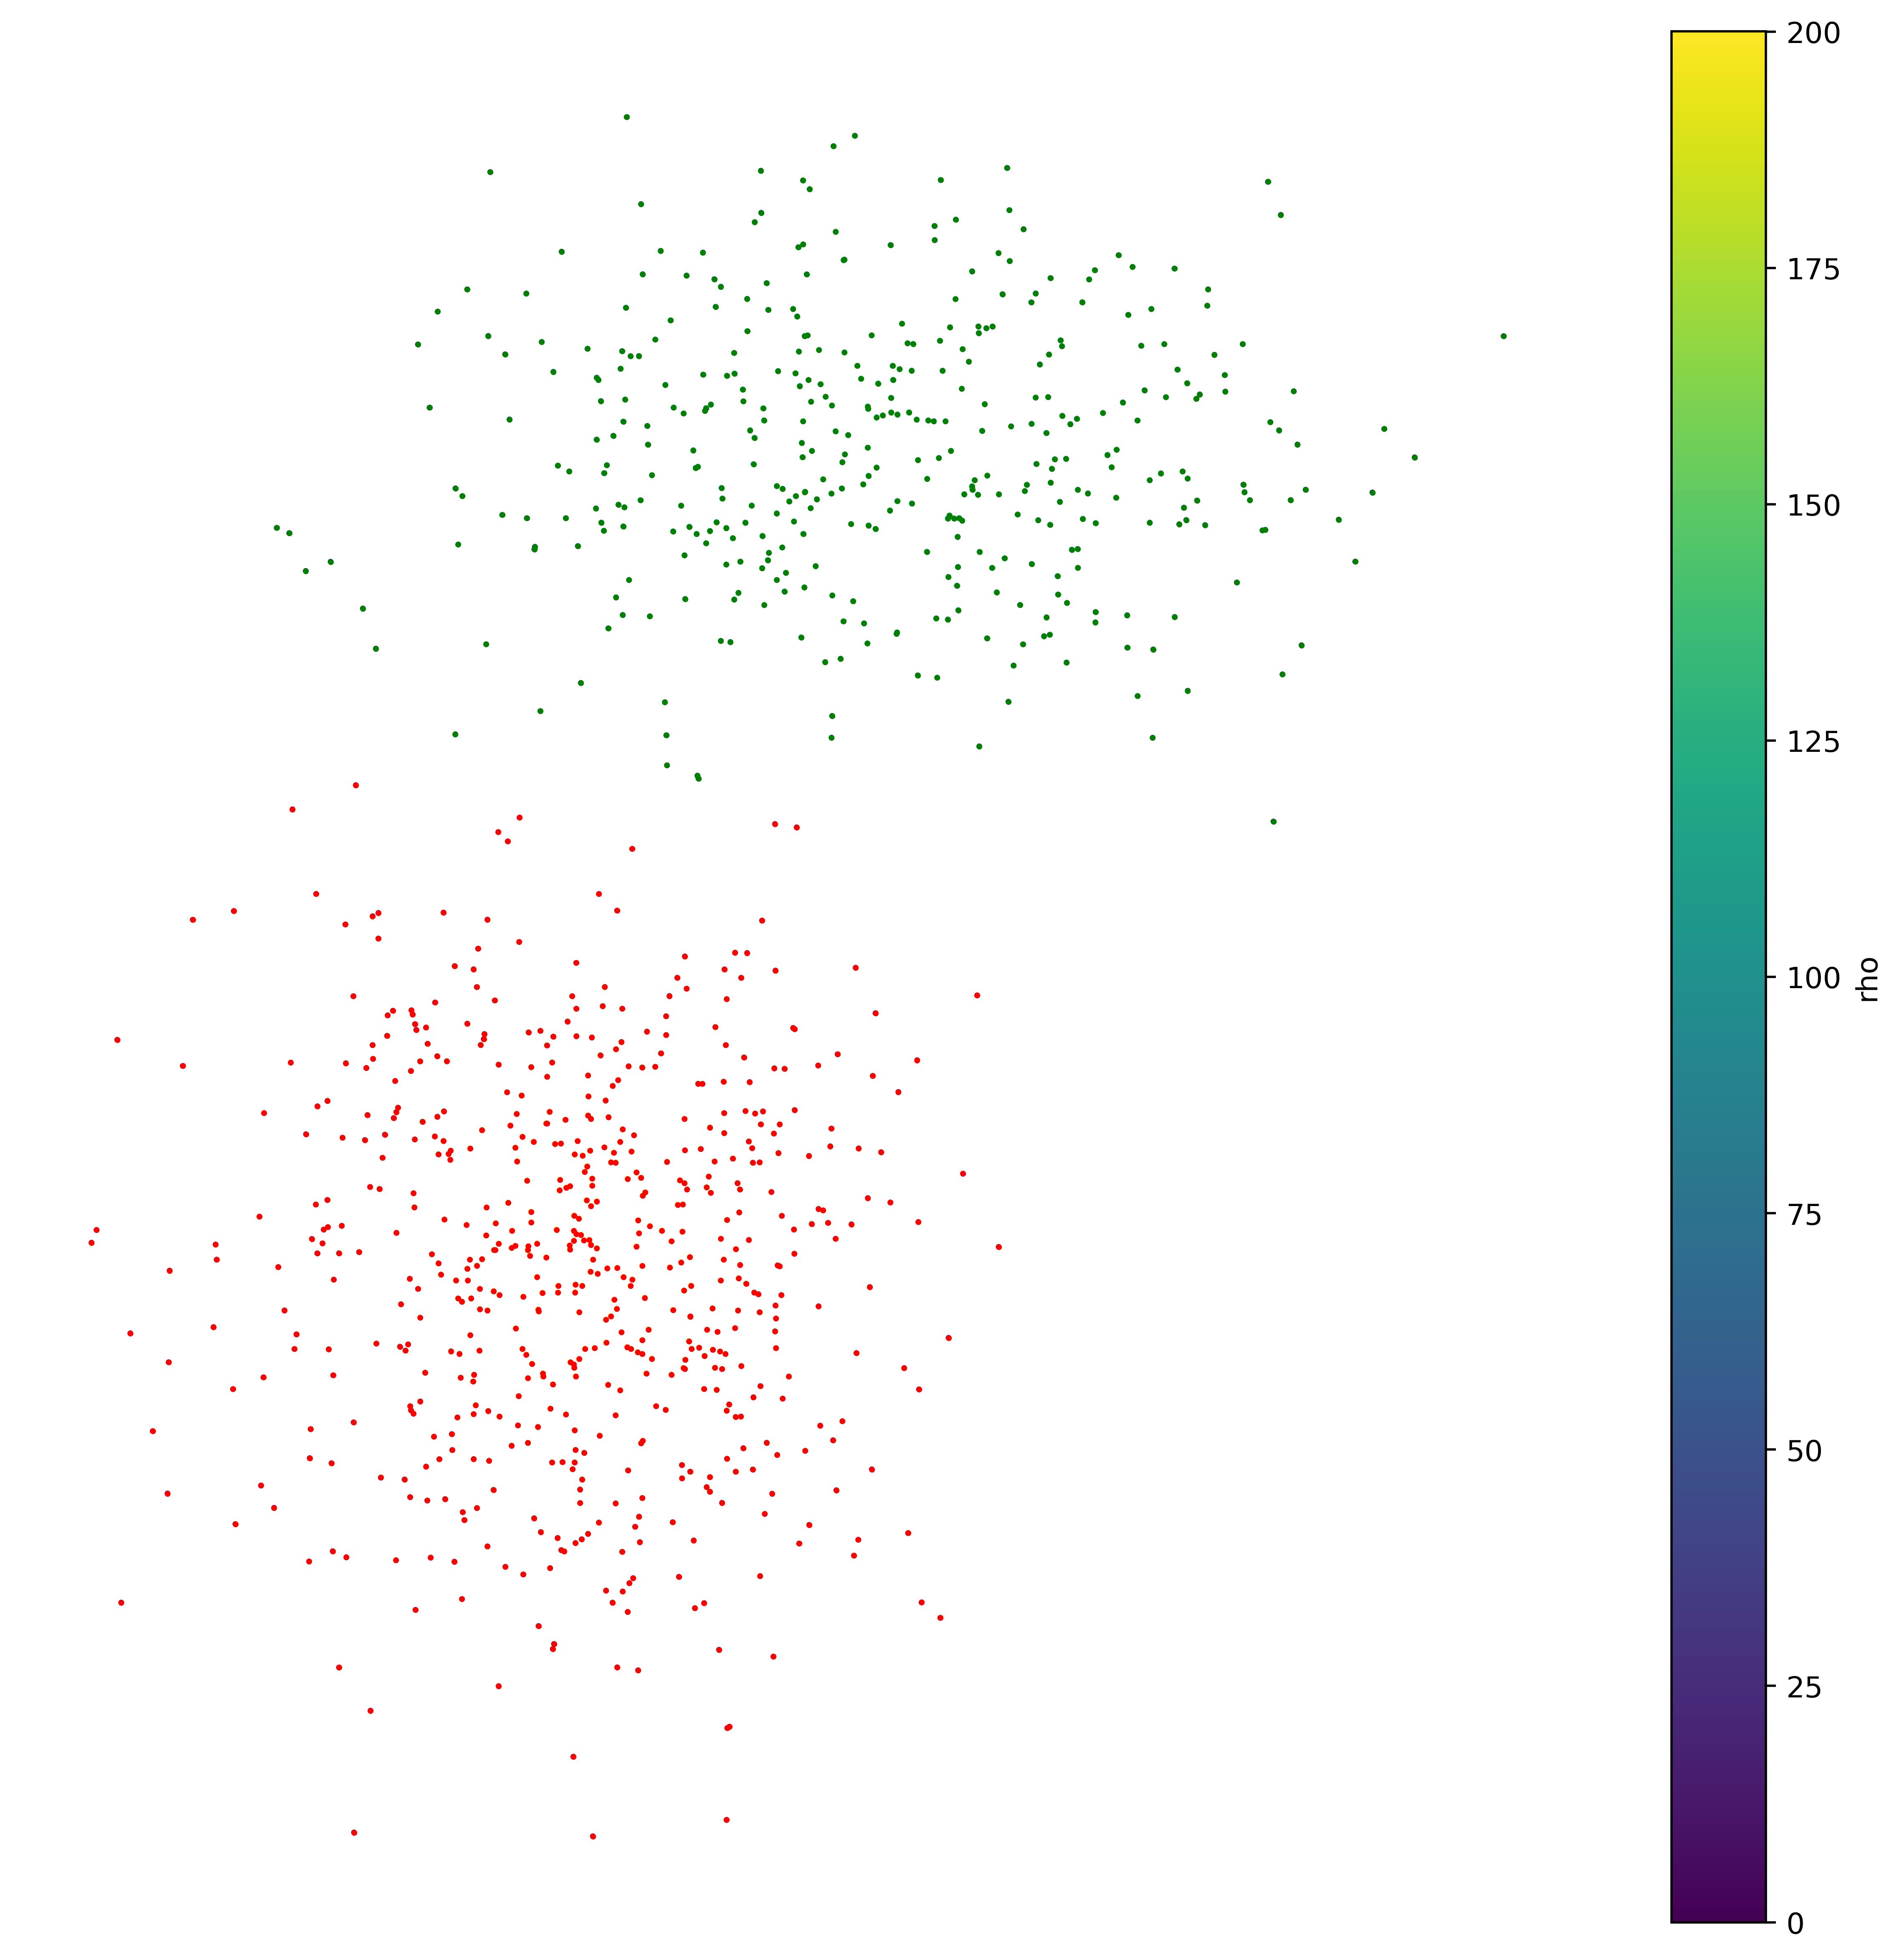

In [3]:
import matplotlib.pyplot as plt
data=dpc.df
fig, ax = plt.subplots(figsize=(12, 12), dpi=500)
# for i, ri in data.drop([512, 343]).iterrows():
#     ax.arrow(ri['x'], ri['y'], data.loc[ri['tmp'], 'x']-ri['x'], data.loc[ri['tmp'], 'y']-ri['y'], lw=0.01, head_width=0.02)
data.plot.scatter(x="x", y='y', s=1, c='rho', cmap='viridis', ax=ax)

colors=['r','g','b','c','m','y','k']
for i, _ in enumerate(dpc.centers):
    data[data.clusterID == i+1].plot.scatter(x="x", y='y', ax=ax, s=1, c=colors[i])
ax.set_axis_off()
